# Import necessary Libraries

In [ ]:
!pip install -U keras-tuner
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import keras_tuner as kt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

# AlexNet and MobileNet
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.applications import MobileNet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.7 MB/s eta 0:00:00


# Load Data

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


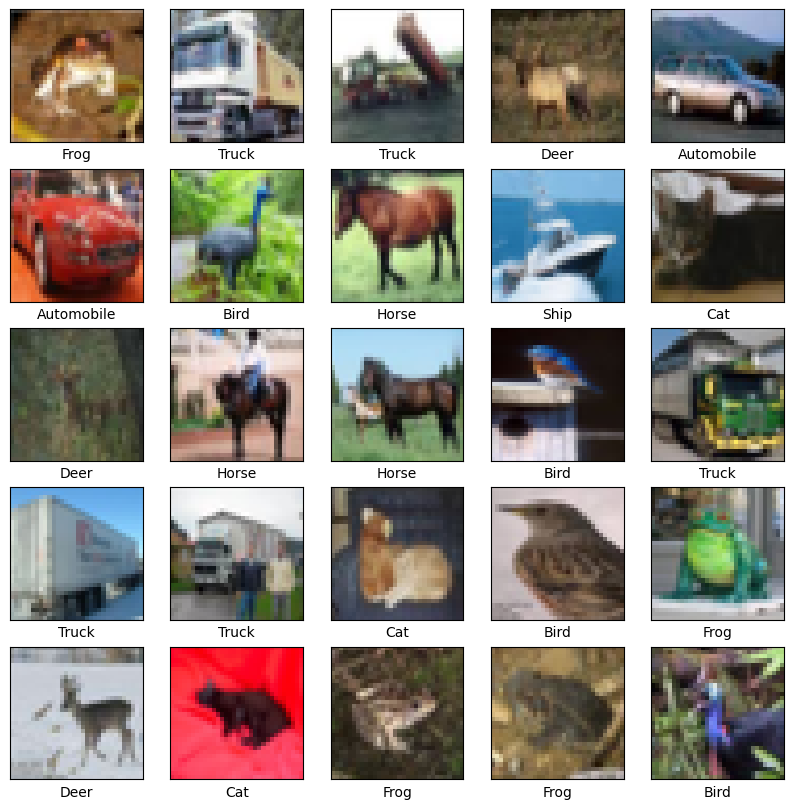

In [ ]:
# Load CIFAR-10 Data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Class Labels
class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# 1. Visualize CIFAR-10 Images
# Briefly visualize some sample images to understand the dataset's classes
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

# 2. Preprocess the Data
# Normalize pixel values and one-hot encode the labels
X_train, X_test = X_train / 255.0, X_test / 255.0
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

# Split Training Set into Training and Validation Sets (45,000 training, 5,000 validation)
X_train, X_val = X_train[:45000], X_train[45000:]
y_train, y_val = y_train[:45000], y_train[45000:]

# Define Data Generator with Augmentation
datagen = ImageDataGenerator(horizontal_flip=True)
datagen.fit(X_train)


# Model Experiments

## 1.AlexNet

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - accuracy: 0.2463 - loss: 1.9937 - val_accuracy: 0.4956 - val_loss: 1.3772
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5229 - loss: 1.3099 - val_accuracy: 0.6046 - val_loss: 1.0825
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6172 - loss: 1.0808 - val_accuracy: 0.6890 - val_loss: 0.9024
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6684 - loss: 0.9372 - val_accuracy: 0.6952 - val_loss: 0.8718
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6941 - loss: 0.8737 - val_accuracy: 0.7108 - val_loss: 0.8223
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7226 - loss: 0.7973 - val_accuracy: 0.7278 - val_loss: 0.7825
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7405 - loss: 0.7452 - val_accuracy: 0.7296 - val_loss: 0.7706
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.7523 - loss: 0.7149 - val_accuracy: 0.7398 - va

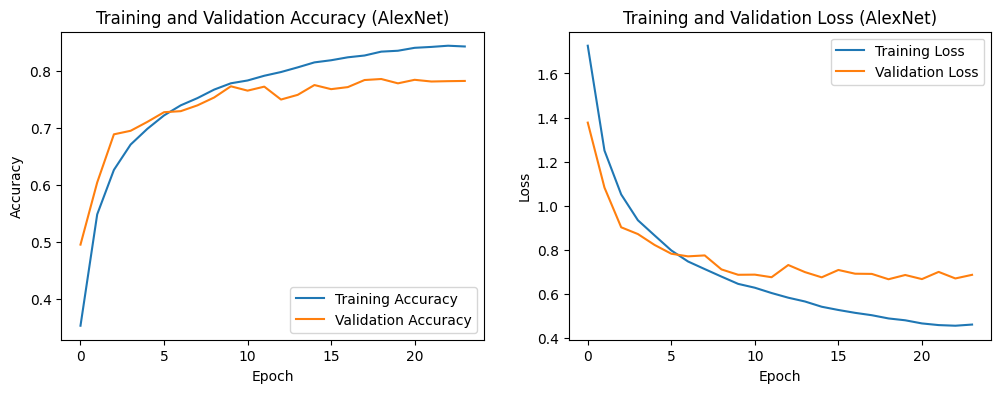

Best Validation Accuracy for AlexNet: 0.79


In [ ]:
# 3. Model Experiments - AlexNet
# Define and train AlexNet to establish a baseline
def create_alexnet_model():
    model = Sequential([
        Conv2D(96, (3, 3), strides=1, activation='relu', padding='same', input_shape=(32, 32, 3)),
        MaxPool2D((2, 2), strides=2),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPool2D((2, 2), strides=2),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(384, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPool2D((2, 2), strides=2),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # CIFAR-10 has 10 classes
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train AlexNet Model
alexnet_model = create_alexnet_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_alexnet = alexnet_model.fit(datagen.flow(X_train, y_train, batch_size=64),
                                    epochs=30, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Plot Training and Validation Curves for AlexNet
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_alexnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (AlexNet)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_alexnet.history['loss'], label='Training Loss')
plt.plot(history_alexnet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (AlexNet)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Print the best validation accuracy
best_val_accuracy = max(history_alexnet.history['val_accuracy'])
print(f"Best Validation Accuracy for AlexNet: {best_val_accuracy:.2f}")


## 2. MobileNet

Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.2346 - loss: 2.1224 - val_accuracy: 0.3294 - val_loss: 1.8964
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4363 - loss: 1.5527 - val_accuracy: 0.4356 - val_loss: 1.7771
Epoch 3/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4987 - loss: 1.4084 - val_accuracy: 0.4798 - val_loss: 1.5434
Epoch 4/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.5246 - loss: 1.3357 - val_accuracy: 0.5370 - val_loss: 1.3531
Epoch 5/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5794 - loss: 1.2018 - val_accuracy: 0.5616 - val_loss: 1.3550
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6062 - loss: 1.1294 - val_accuracy: 0.5594 - val_loss: 1.2537
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.6401 - loss: 1.0294 - val_accuracy: 0.5920 - val_loss: 1.2395
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6642 - loss: 0.9785 - val_accuracy: 

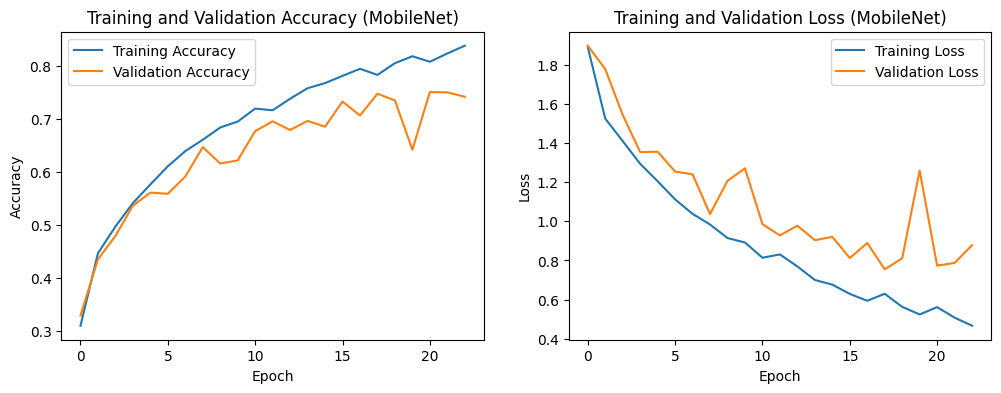

Best Validation Accuracy of MobileNet Model: 0.7514


In [ ]:
# Define MobileNet Model
def create_mobilenet_model():
    base_model = MobileNet(weights=None, include_top=False, input_shape=(32, 32, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    output = Dense(10, activation='softmax')(x)  # CIFAR-10 has 10 classes
    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Train MobileNet Model
mobilenet_model = create_mobilenet_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_mobilenet = mobilenet_model.fit(datagen.flow(X_train, y_train, batch_size=64),
                                        epochs=30,
                                        validation_data=(X_val, y_val),
                                        callbacks=[early_stopping])

# Plot Training and Validation Accuracy and Loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (MobileNet)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_mobilenet.history['loss'], label='Training Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MobileNet)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Print the best validation accuracy
best_val_accuracy = max(history_mobilenet.history['val_accuracy'])
print(f"Best Validation Accuracy of MobileNet Model: {best_val_accuracy:.4f}")


I used AlexNet and MobileNet as base models for their lightweight architectures. To improve accuracy, I selected ResNet-18, a deeper model, and am tuning various hyperparameters to observe if accuracy improves.

# 3. Resnet-18



*   Resnet-18 learning rate 0.0001,ADAM optimizer

Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 43s 17ms/step - accuracy: 0.4345 - loss: 1.5708 - val_accuracy: 0.6072 - val_loss: 1.0923
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6833 - loss: 0.9043 - val_accuracy: 0.6140 - val_loss: 1.1089
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7875 - loss: 0.6118 - val_accuracy: 0.7128 - val_loss: 0.8423
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8652 - loss: 0.3872 - val_accuracy: 0.6908 - val_loss: 1.0263
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9226 - loss: 0.2274 - val_accuracy: 0.7278 - val_loss: 1.0254
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9471 - loss: 0.1579 - val_accuracy: 0.7490 - val_loss: 0.9886
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9563 - loss: 0.1232 - val_accuracy: 0.7338 - val_loss: 1.0817
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9623 - loss: 

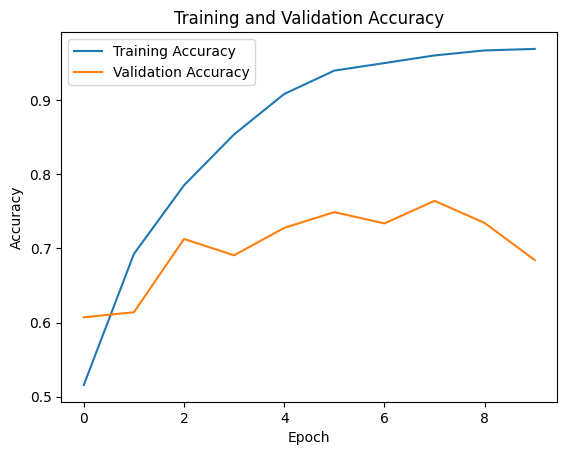

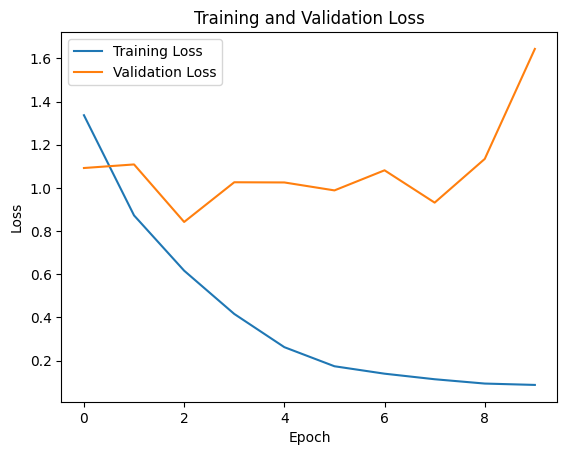

Best Validation Accuracy: 0.7642


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Residual Block for ResNet-18
def residual_block(x, filters, stride=1):
    shortcut = x

    # First convolutional layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut to match the output shape if needed
    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Building ResNet-18 model from scratch
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial Convolutional layer
    x = Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Define ResNet-18 Architecture
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    # Global average pooling and output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    return model



# Instantiate ResNet-18 model
model = build_resnet18(input_shape=(32, 32, 3), num_classes=10)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Train the model
history = model.fit(X_train, y_train,epochs=10,validation_data=(X_val, y_val))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Find and print the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")




*   Resnet-18 with learning rate of 0.01, momemtum-0.9, sdg optimizer




Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - accuracy: 0.3972 - loss: 1.7614 - val_accuracy: 0.6006 - val_loss: 1.1630
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6872 - loss: 0.8927 - val_accuracy: 0.7258 - val_loss: 0.8215
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7877 - loss: 0.6021 - val_accuracy: 0.7640 - val_loss: 0.6952
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8510 - loss: 0.4280 - val_accuracy: 0.7720 - val_loss: 0.7011
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8970 - loss: 0.2912 - val_accuracy: 0.7560 - val_loss: 0.8204
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9331 - loss: 0.1953 - val_accuracy: 0.7518 - val_loss: 1.0182
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9528 - loss: 0.1340 - val_accuracy: 0.7900 - val_loss: 0.8395
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9640 - loss: 

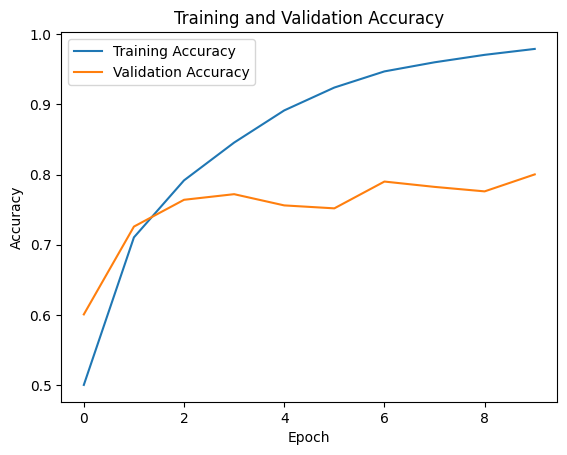

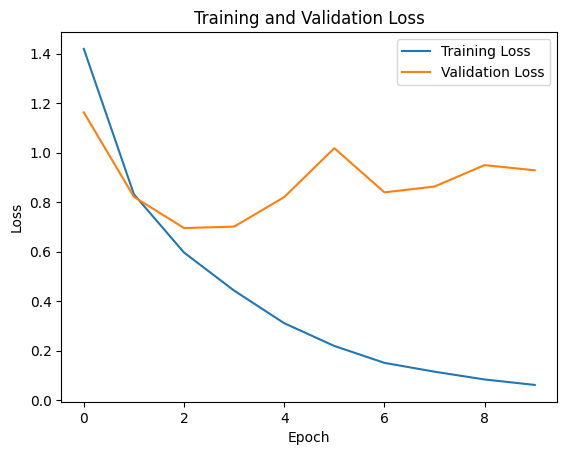

Best Validation Accuracy: 0.8002


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Residual Block for ResNet-18
def residual_block(x, filters, stride=1):
    shortcut = x

    # First convolutional layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut to match the output shape if needed
    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Building ResNet-18 model from scratch
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial Convolutional layer
    x = Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Define ResNet-18 Architecture
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    # Global average pooling and output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    return model



# Instantiate ResNet-18 model
model = build_resnet18(input_shape=(32, 32, 3), num_classes=10)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Train the model
history = model.fit(X_train, y_train,epochs=10,validation_data=(X_val, y_val))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


# Find and print the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")



*   Resnet-18 learning rate 0.01 and ADAM optimizer.




Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 36s 15ms/step - accuracy: 0.2873 - loss: 2.1358 - val_accuracy: 0.3306 - val_loss: 1.9832
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.5519 - loss: 1.2446 - val_accuracy: 0.6438 - val_loss: 1.0268
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.6839 - loss: 0.8960 - val_accuracy: 0.6172 - val_loss: 1.1114
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7615 - loss: 0.6784 - val_accuracy: 0.7384 - val_loss: 0.7627
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8260 - loss: 0.4995 - val_accuracy: 0.7310 - val_loss: 0.7681
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8785 - loss: 0.3528 - val_accuracy: 0.7776 - val_loss: 0.6804
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9141 - loss: 0.2445 - val_accuracy: 0.8168 - val_loss: 0.5756
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9419 - loss: 

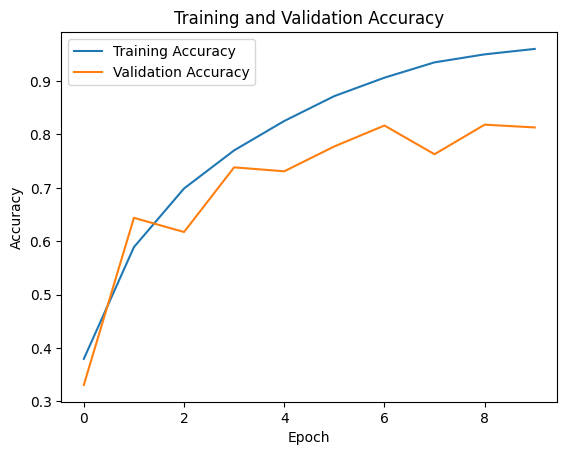

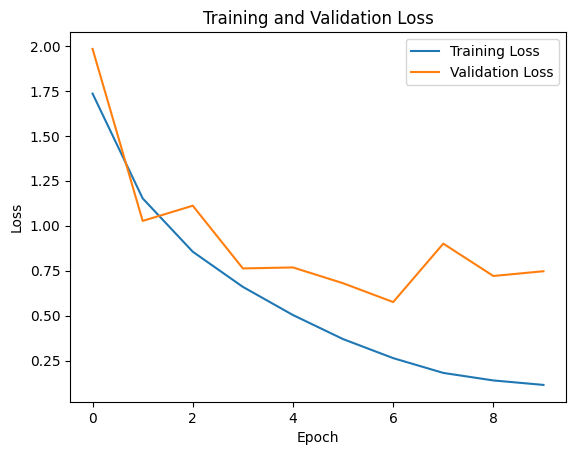

Best Validation Accuracy: 0.8184


In [ ]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Residual Block for ResNet-18
def residual_block(x, filters, stride=1):
    shortcut = x

    # First convolutional layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut to match the output shape if needed
    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Building ResNet-18 model from scratch
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial Convolutional layer
    x = Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Define ResNet-18 Architecture
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    # Global average pooling and output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    return model



# Instantiate ResNet-18 model
model = build_resnet18(input_shape=(32, 32, 3), num_classes=10)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Train the model
history = model.fit(X_train, y_train,epochs=10,validation_data=(X_val, y_val))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Find and print the best validation accuracy
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")




*   resnet with learning of 0.001 and Adam optimizer




Epoch 1/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - accuracy: 0.4502 - loss: 1.5660 - val_accuracy: 0.6360 - val_loss: 1.0799
Epoch 2/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7114 - loss: 0.8196 - val_accuracy: 0.7024 - val_loss: 0.9256
Epoch 3/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7954 - loss: 0.5844 - val_accuracy: 0.7588 - val_loss: 0.7272
Epoch 4/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8465 - loss: 0.4401 - val_accuracy: 0.7618 - val_loss: 0.6883
Epoch 5/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.8791 - loss: 0.3403 - val_accuracy: 0.7890 - val_loss: 0.6845
Epoch 6/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9163 - loss: 0.2373 - val_accuracy: 0.8130 - val_loss: 0.5782
Epoch 7/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9447 - loss: 0.1569 - val_accuracy: 0.8132 - val_loss: 0.6403
Epoch 8/10
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.9603 - loss: 

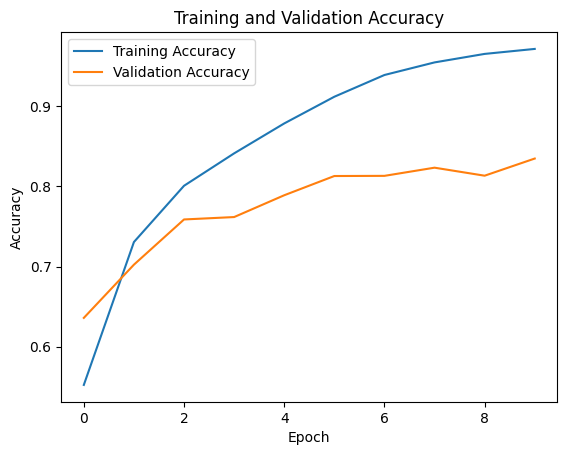

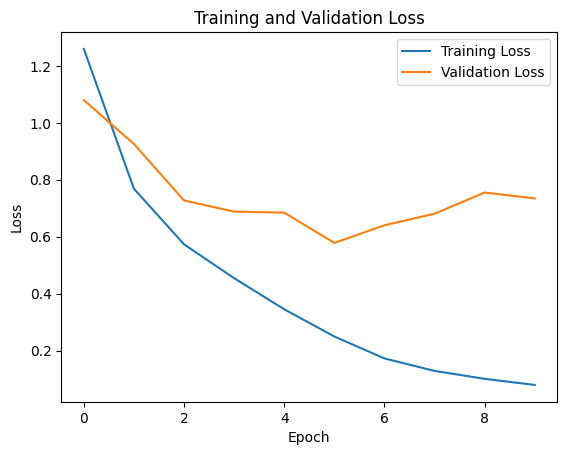

Best Validation Accuracy: 0.8348


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Residual Block for ResNet-18
def residual_block(x, filters, stride=1):
    shortcut = x

    # First convolutional layer
    x = Conv2D(filters, (3, 3), strides=stride, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolutional layer
    x = Conv2D(filters, (3, 3), strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)

    # Adjust the shortcut to match the output shape if needed
    if stride != 1:
        shortcut = Conv2D(filters, (1, 1), strides=stride, padding='same', use_bias=False)(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # Add shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)

    return x

# Building ResNet-18 model from scratch
def build_resnet18(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)

    # Initial Convolutional layer
    x = Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False)(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Define ResNet-18 Architecture
    x = residual_block(x, 64, stride=1)
    x = residual_block(x, 64, stride=1)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)

    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512, stride=1)

    # Global average pooling and output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs)
    return model



# Instantiate ResNet-18 model
model = build_resnet18(input_shape=(32, 32, 3), num_classes=10)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Train the model
history = model.fit(X_train, y_train,epochs=10,validation_data=(X_val, y_val))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Get the best validation accuracy during training
best_val_accuracy = max(history.history['val_accuracy'])
print(f"Best Validation Accuracy: {best_val_accuracy:.4f}")

# Choosing the best model:


After testing multiple models, the validation accuracies are as follows:



*   AlexNet - 0.79

*   MobileNet - 0.7514

*   ResNet-18 (learning rate 0.0001, ADAM) - 0.7642
*   ResNet-18 (learning rate 0.01, momentum 0.9, SGD) - 0.8002


*   ResNet-18 (learning rate 0.01, ADAM) - 0.8184


*   ResNet (learning rate 0.001, ADAM) - 0.8348

The ResNet model with a 0.001 learning rate and ADAM optimizer performed the best in validation, so I’ll proceed to test it on the unseen test data to assess its generalization.

# Test Data

Test Accuracy: 0.8217
Test Loss: 0.7785
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 2000x1600 with 0 Axes>

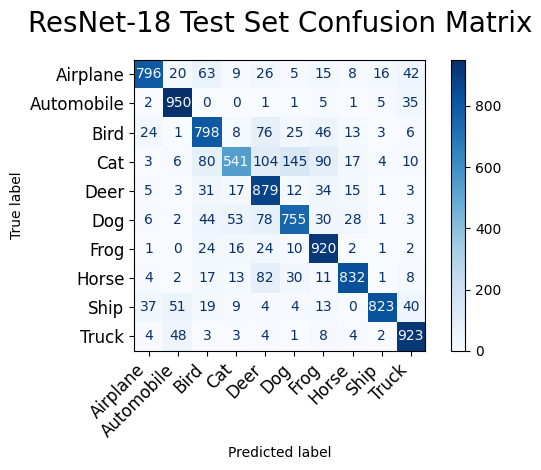

ResNet-18 Test Set Classification Report
              precision    recall  f1-score   support

    Airplane       0.90      0.80      0.85      1000
  Automobile       0.88      0.95      0.91      1000
        Bird       0.74      0.80      0.77      1000
         Cat       0.81      0.54      0.65      1000
        Deer       0.69      0.88      0.77      1000
         Dog       0.76      0.76      0.76      1000
        Frog       0.78      0.92      0.85      1000
       Horse       0.90      0.83      0.87      1000
        Ship       0.96      0.82      0.89      1000
       Truck       0.86      0.92      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.83      0.82      0.82     10000
weighted avg       0.83      0.82      0.82     10000

Test Accuracy: 0.8217
Test Loss: 0.7785


In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions for the test set
y_pred_test = model.predict(X_test)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_true_test = np.argmax(y_test, axis=1)

# Confusion Matrix and Classification Report
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Set an even larger figure size
plt.figure(figsize=(20, 16))

# Create confusion matrix with larger font sizes
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_true_test,
    y_pred_classes_test,
    display_labels=class_names,
    cmap='Blues',
)

# Increase font sizes and rotate x-axis labels
plt.title("ResNet-18 Test Set Confusion Matrix", fontsize=20, pad=20)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.show()

# Print the classification report
print("ResNet-18 Test Set Classification Report")
print(classification_report(y_true_test, y_pred_classes_test, target_names=class_names))
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Conclusion:

The selected ResNet model, with a learning rate of 0.001 and the ADAM optimizer, achieved a test accuracy of 0.8217, demonstrating effective generalization on unseen data. While additional hyperparameter tuning could potentially enhance performance, computational resource constraints limit further experimentation. Thus, the ResNet model with these settings stands as the best model for this task at present.